<a href="https://colab.research.google.com/github/MateoVB/AIT-Deep-Learning/blob/main/GAN_sequential_en_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

<PRE>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.

Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
</PRE>

## Training GANs with sequential data
In this notebook, we show how to learn one-dimensional sequential data with Generative Adversarial Network (GAN) and how to generate patterns.

Please fill the \<TODO\> parts.

## Imports

In [ ]:
import numpy as np
import copy
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Conv1D, Flatten
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

## Data
Create a superposed sine function with random noise - something similar, that can be seen on the figure:

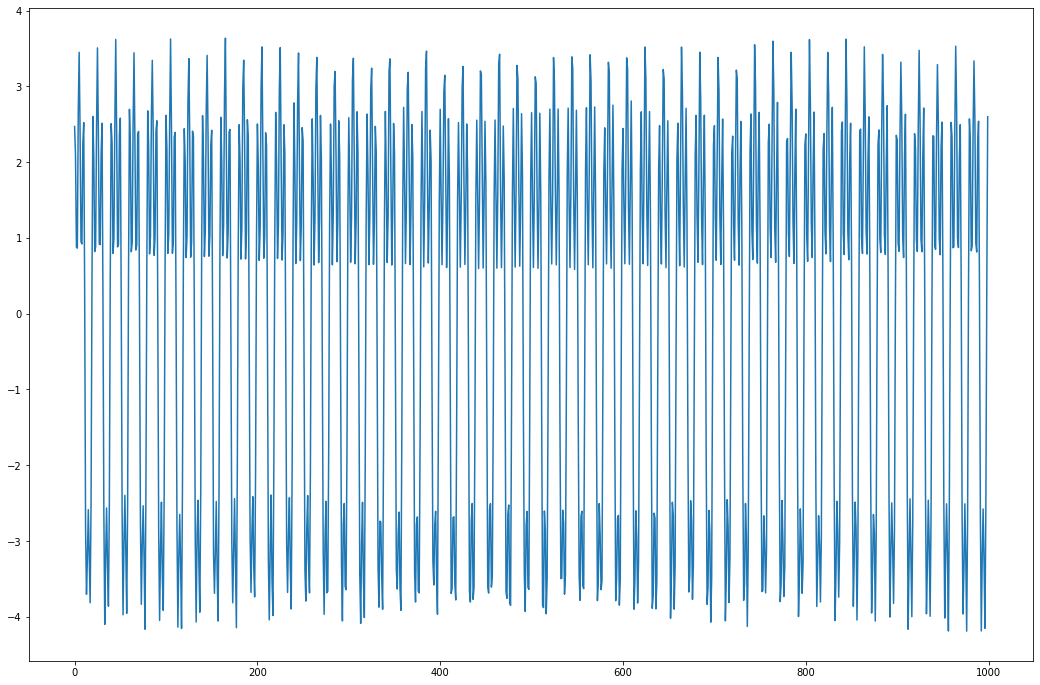

In [ ]:
data_length = 1000
lp          = np.linspace(-50*np.pi, 50*np.pi, data_length)
data        = <TODO>
plt.figure(figsize=(18,12))
plt.plot(data)

Then prepare the three-dimensional data:

In [ ]:
window_size = 40
data = np.asarray(data)/<TODO> # scale the data to 0...1 region
X = np.array( [ data[start:start+window_size] for start in range(0,len(data)-window_size)] )
X = np.atleast_3d(X)
print(X.shape)

(960, 40, 1)


## Model
Create the generator and the discriminator:

In [ ]:
adam_optim = Adam(0.0002, 0.5)

def define_generator(window_size,input_dim):
    model = Sequential()
    model.add(Conv1D(3, 3,  input_shape=(window_size,input_dim,), padding='same', activation='relu'))
    model.add(Conv1D(<TODO>))
    model.add(Conv1D(<TODO>))
    model.add(Conv1D(<TODO>))
    model.add(TimeDistributed(Dense(input_dim, activation='linear')))
    return model

def define_discriminator(window_size,input_dim):
    model = Sequential()
    model.add(Conv1D(3, 3,  input_shape=(window_size,input_dim,), padding='same', activation='relu'))
    model.add(Conv1D(<TODO>))
    model.add(Conv1D(<TODO>))
    model.add(Conv1D(<TODO>))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # the discriminator must be compiled to train it for classification
    model.compile(loss='<TODO>', optimizer=adam_optim, metrics=['accuracy']) # define a loss function for the disctiminator that classifies data to fake and real
    return model

Next, we create a function defining a GAN that connects the two (generator and discriminator) competing networks:

In [ ]:
def define_gan(generator, discriminator):
    model = Sequential()
    model.add(<TODO>) # add the generator the the GAN
    model.add(<TODO>) # add the discriminator to the GAN
    model.compile(loss='binary_crossentropy', optimizer=adam_optim, metrics=['accuracy']) # define a loss function for the GAN  that classifies data to fake and real
    return model

Then the real data and the noise generating functions are given:

In [ ]:
# randomly take n samples from the data
# 1 is given as output
def get_real_samples(n, X):
    y = np.ones((n, 1))
    idx = np.random.randint(X.shape[0], size=n)
    return X[idx], y

# create noisy data
def generate_latent_points(n, window_size, features):
    x_input = np.random.randn(n*window_size * features)
    x_input = x_input.reshape(n, window_size, features)
    return x_input

# generate noisy data, prediction with the generator and
# output is set to 0
def get_fake_samples(generator, n, window_size, features):
    x_input = generate_latent_points(n, window_size, features)
    x_latent = generator.predict(x_input)
    y = np.zeros((n, 1))
    return x_latent, y

The function that monitor the performance of GAN numerically and also visualizes it.

In [ ]:
def summarize_performance(epoch, generator, discriminator, window_size, n=100):
    # evaluation on real data
    x_real, y_real = <TODO> # from the function above
    _, acc_real = <TODO> # get the accuracy of the discriminator with evaluate function for real data
    # evaluation on false data
    x_fake, y_fake = <TODO> # from the function above
    _, acc_fake = <TODO> # get the accuracy of the discriminator with evaluate function for fake data
    print(epoch, "epoch, Recognizing real data:", acc_real, ", Recognizing fake data:",acc_fake)
    # visualize the samples
    for i in range(x_real.shape[0]):
        plt.plot(x_real[i, :, 0], color='red')
        plt.plot(x_fake[i, :, 0], color='blue')
    plt.ylim(-1, 5)
    plt.xlim(0,window_size)
    plt.show()
    return acc_real, acc_fake

The model is defined in two steps: first, we construct a learnable discriminator, and second, we incorporate the discriminator with frozen weights into the full GAN:

In [ ]:
patience       = 20
batch_size     = 256
nb_epochs      = 10000
input_dim      = X.shape[-1]

model_gen     = define_generator(window_size, 1)
model_dis     = define_discriminator(window_size, 1)

frozen_discriminator = Model(model_dis.inputs, model_dis.outputs)
frozen_discriminator.trainable = False
# create the gan
model_gan = define_gan(model_gen, frozen_discriminator)

In [ ]:
print(model_gen.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 40, 3)             12        
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 40, 3)             30        
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 40, 6)             60        
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 40, 6)             114       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 1)             7         
Total params: 223
Trainable params: 223
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print(model_dis.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 40, 3)             12        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 40, 3)             30        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 40, 3)             30        
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 40, 3)             30        
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 121       
Total params: 223
Trainable params: 0
Non-trainable params: 223
________________________________________________________

## Training the network
The GAN is trained in two steps:
* first, the discriminator is trained to distinguish between real and fake data.
* then, with the discriminator weights frozen, we train the generator part of the entire network to transform the noise so that the discriminator considers it to be real data.

In [ ]:
eval_no = 10
acc_real, acc_fake = 0, 0
for i in range(nb_epochs):
    # generating and mixing real and fake data
    x_real, y_real = <TODO> # half of the batch should be real samples with the function we defined above
    x_fake, y_fake = <TODO> # half of the batch should be fake samples with the function we defined above
    x_dis, y_dis   = np.concatenate([x_real,x_fake]),np.concatenate([y_real,y_fake])
    perm           = np.random.permutation(x_dis.shape[0])
    x_dis, y_dis   = x_dis[perm],y_dis[perm] # shuffle the batch
    # training the discriminator
    model_dis.train_on_batch(x_dis, y_dis)

    # Train the complete GAN with noise, discriminator is frozen
    # and 1 is predicted (forcing to generator to generate real-like data)
    x_gan = <TODO> # generate batch sized latent points
    y_gan = <TODO> # define "real" labels for the fake input as target variable
    model_gan.train_on_batch(x_gan, y_gan)
    # display of results and training stop criteria
    if (i%eval_no)==0:
        acc_real, acc_fake = summarize_performance(i, model_gen, model_dis, window_size)
        # training stop criteria
        if i>1000 and acc_real>0.7:
          print("Stopping training")
          break


At the end of the training let us check how discriminator works on the complete dataset:

In [ ]:
preds = model_dis.predict(X)

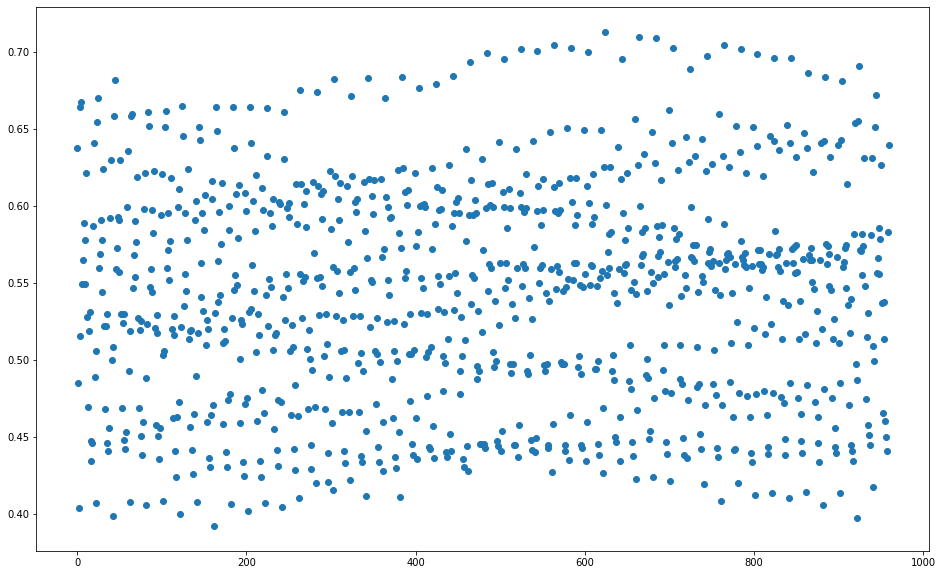

In [ ]:
plt.figure(figsize=(16,10))
rng = np.arange(len(preds))
plt.scatter(rng, preds)

In [ ]:
min_val, max_val = np.min(preds), np.max(preds)

## Anomaly detection
Add minimal anomalies to the data and try to detect them automatically using the trained discriminator:

In [ ]:
np.random.seed(42)
no_anomalies    = <TODO>
anomaly_samples = np.arange(len(data))
np.random.shuffle(anomaly_samples)
anomaly_samples = anomaly_samples[:no_anomalies]
print("The position of anomalies in the data:",anomaly_samples)

In [ ]:
anomaly_length = 2
anomaly_data = copy.copy(data)
for start in anomaly_samples:
    anomaly_data[start:start+anomaly_length] = anomaly_data[start:start+anomaly_length]/((np.random.rand(anomaly_length)+1)*4)

X_anomaly = np.array( [ anomaly_data[start:start+window_size] for start in range(0,len(anomaly_data)-window_size)] )
X_anomaly = np.atleast_3d(X_anomaly)

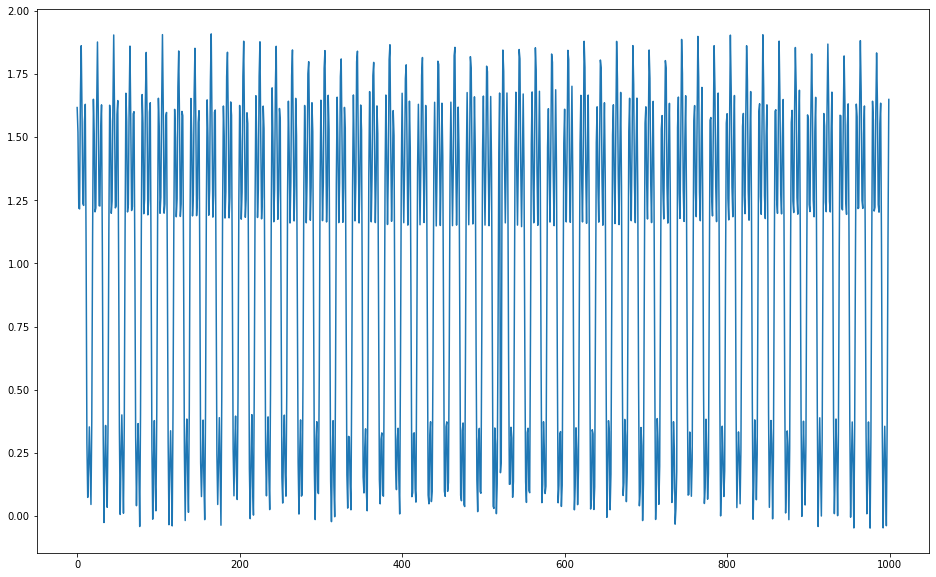

In [ ]:
plt.figure(figsize=(16,10))
plt.plot(anomaly_data)

Anomalies in the real data stream are hard to spot, so let's see how GAN performs:

In [ ]:
preds = model_dis.predict(X_anomaly)

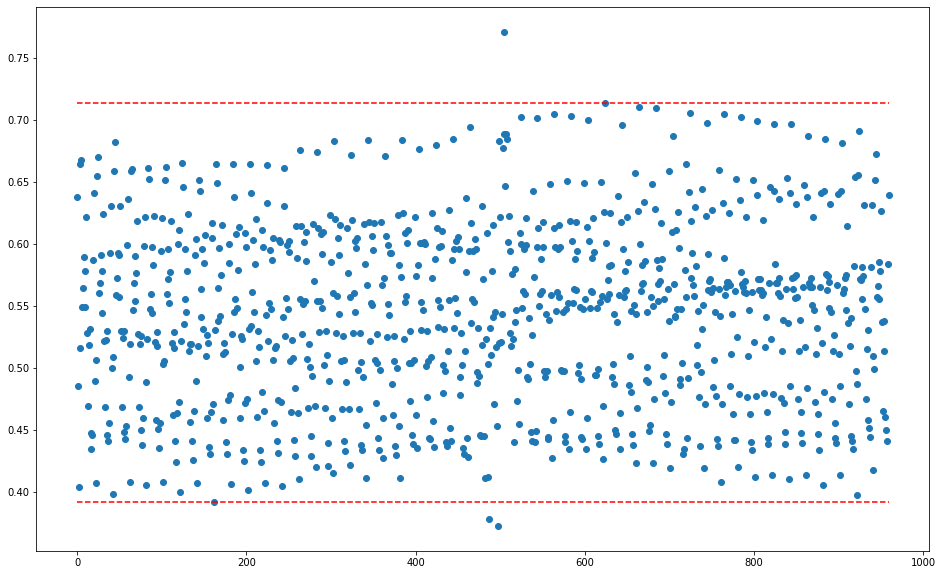

In [ ]:
plt.figure(figsize=(16,10))
rng = np.arange(len(preds))
plt.scatter(rng, preds)
horiz_line_min = np.array([min_val for i in range(len(preds))])
horiz_line_max = np.array([max_val for i in range(len(preds))])
plt.plot(rng, horiz_line_min, 'r--')
plt.plot(rng, horiz_line_max, 'r--')

The GAN results should be observed for deviations in the positive or negative direction from the previous band. In this case, the anomalies are nicely highlighted: the first more pronounced in the negative direction, the second less pronounced, also in the negative direction.